# Richter's Predictor

Initial code is a copy of the example found here: http://drivendata.co/blog/richters-predictor-benchmark/

We'll then use an XGBoost model to get a better estimate, and also will look at engineering some features using the geocode.

The intention is to try to find a way to use the fact that some areas (geo locations) will have suffered more damage than others.  There seem to be too many level 3 geolocations for a tree-based algorithm to deal with effectively, but if we can somehow uncover information about the geolocation and encode it in a way that is easier for the tree to deal with then it may improve our scores

In [14]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# for preprocessing the data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import defaultdict

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
DATA_DIR = Path('.', 'data')

In [3]:
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')


In [4]:
train_labels.head()

damage_grade
building_id              
802906                  3
28830                   2
94947                   3
590882                  2
201944                  3

In [5]:
train_values.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906                    6             487           12198   
28830                     8             900            2812   
94947                    21             363            8973   
590882                   22             418           10694   
201944                   11             131            1488   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
802906                         2   30                6                  5   
28830                          2   10                8                  7   
94947                          2   10                5                  5   
590882                         2   10                6                  5   
201944                         3   30                8                  9   

            land_surface_condition foundation_type roof_type  \
building_id                                                    
802906                           t               r         n   
28830                            o               r         n   
94947                            t               r         n   
590882                           t               r         n   
201944                           t               r         n   

                      ...            has_secondary_use_agriculture  \
building_id           ...                                            
802906                ...                                        0   
28830                 ...                                        0   
94947                 ...                                        0   
590882                ...                                        0   
201944                ...                                        0   

            has_secondary_use_hotel has_secondary_use_rental  \
building_id                                                    
802906                            0                        0   
28830                             0                        0   
94947                             0                        0   
590882                            0                        0   
201944                            0                        0   

            has_secondary_use_institution  has_secondary_use_school  \
building_id                                                           
802906                                  0                         0   
28830                                   0                         0   
94947                                   0                         0   
590882                                  0                         0   
201944                                  0                         0   

             has_secondary_use_industry  has_secondary_use_health_post  \
building_id                                                              
802906                                0                              0   
28830                                 0                              0   
94947                                 0                              0   
590882                                0                              0   
201944                                0                              0   

             has_secondary_use_gov_office  has_secondary_use_use_police  \
building_id                                                               
802906                                  0                             0   
28830                                   0                             0   
94947                                   0                             0   
590882                                  0                             0   
201944                                  0                             0   

             has_secondary_use_other  
building_id                           
802906               

In [6]:
train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

## Data exploration

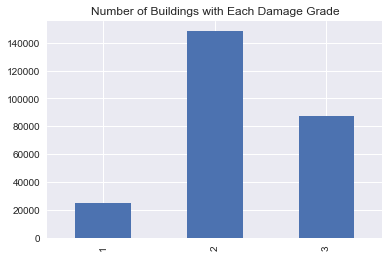

In [7]:
(train_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

In [8]:
selected_features = ['foundation_type', 
                     'area_percentage', 
                     'height_percentage',
                     'count_floors_pre_eq',
                     'land_surface_condition',
                     'has_superstructure_cement_mortar_stone']

train_values_subset = train_values[selected_features]

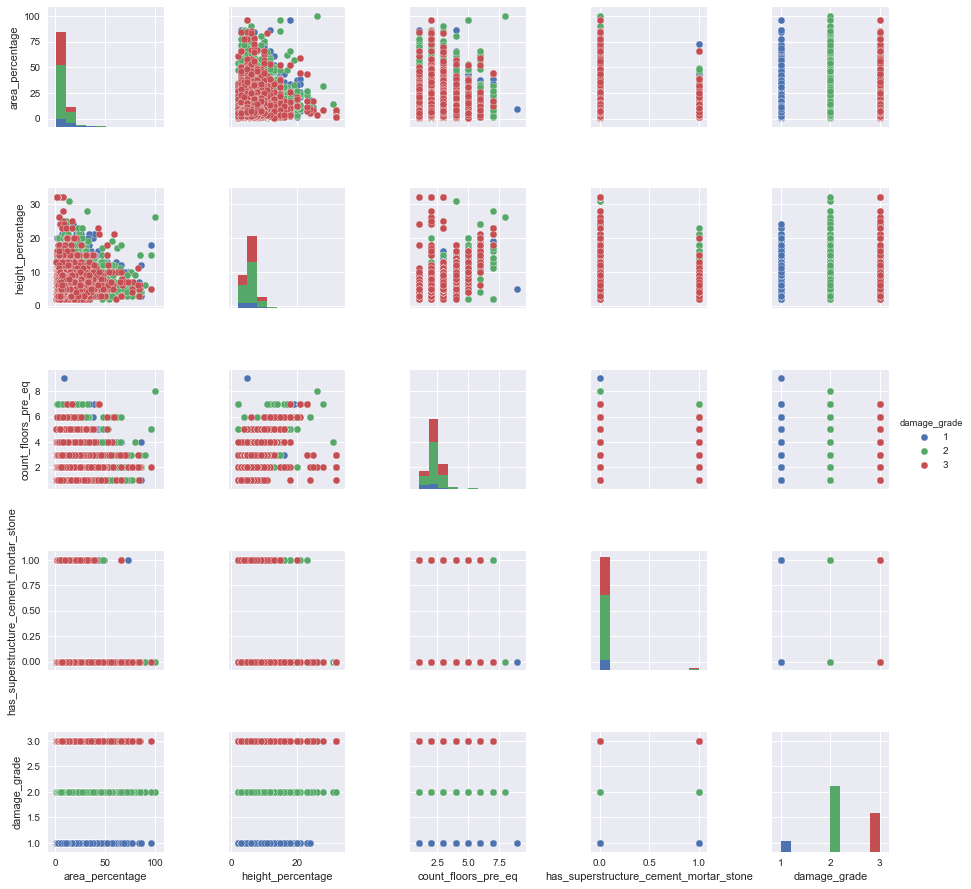

In [9]:
sns.pairplot(train_values_subset.join(train_labels), 
             hue='damage_grade')

In [42]:
secondary_uses = [
'has_secondary_use',
'has_secondary_use_agriculture',
'has_secondary_use_hotel',
'has_secondary_use_rental',
'has_secondary_use_institution',
'has_secondary_use_school',
'has_secondary_use_industry',
'has_secondary_use_health_post',
'has_secondary_use_gov_office',
'has_secondary_use_use_police',
'has_secondary_use_other'
]

structure = [
'has_superstructure_adobe_mud',
'has_superstructure_mud_mortar_stone',
'has_superstructure_stone_flag',
'has_superstructure_cement_mortar_stone',
'has_superstructure_mud_mortar_brick',
'has_superstructure_cement_mortar_brick',
'has_superstructure_timber',
'has_superstructure_bamboo',
'has_superstructure_rc_non_engineered',
'has_superstructure_rc_engineered',
'has_superstructure_other'
]



In [37]:
for use in secondary_uses:
    print(use, train[train[use]==1]['damage_grade'].mean())

has_secondary_use 2.1010083687748664
has_secondary_use_agriculture 2.2646480300411276
has_secondary_use_hotel 1.917037544220016
has_secondary_use_rental 1.6712458550450024
has_secondary_use_institution 1.6653061224489796
has_secondary_use_school 1.8617021276595744
has_secondary_use_industry 2.032258064516129
has_secondary_use_health_post 1.8571428571428572
has_secondary_use_gov_office 1.763157894736842
has_secondary_use_use_police 2.130434782608696
has_secondary_use_other 2.098950524737631


In [46]:
for s in structure:
    print(s, train[train[s]==1]['damage_grade'].mean())

has_superstructure_adobe_mud 2.3467815246093244
has_superstructure_mud_mortar_stone 2.337901199127724
has_superstructure_stone_flag 2.4525539286911813
has_superstructure_cement_mortar_stone 1.9675925925925926
has_superstructure_mud_mortar_brick 2.271212206519903
has_superstructure_cement_mortar_brick 1.6932959469793525
has_superstructure_timber 2.165221971407073
has_superstructure_bamboo 2.111717974180735
has_superstructure_rc_non_engineered 1.7795296873592215
has_superstructure_rc_engineered 1.3755141543672877
has_superstructure_other 2.088348271446863


In [49]:
biggest_geo3 = train['geo_level_3_id'].value_counts().head(30).index.values

In [60]:
for location in biggest_geo3:
    print('Geo3 id:',location)
    for s in structure:
        s_filter = (train['geo_level_3_id'] == location) & (train[s] == 1)
        print(s, train.loc[s_filter]['damage_grade'].count(), train.loc[s_filter]['damage_grade'].mean())

Geo3 id: 633
has_superstructure_adobe_mud 0 nan
has_superstructure_mud_mortar_stone 1 1.0
has_superstructure_stone_flag 1 1.0
has_superstructure_cement_mortar_stone 4 1.5
has_superstructure_mud_mortar_brick 13 1.9230769230769231
has_superstructure_cement_mortar_brick 375 1.48
has_superstructure_timber 5 1.8
has_superstructure_bamboo 1 1.0
has_superstructure_rc_non_engineered 93 1.4623655913978495
has_superstructure_rc_engineered 245 1.3551020408163266
has_superstructure_other 3 2.3333333333333335
Geo3 id: 9133
has_superstructure_adobe_mud 4 1.25
has_superstructure_mud_mortar_stone 14 1.5714285714285714
has_superstructure_stone_flag 2 2.0
has_superstructure_cement_mortar_stone 11 1.1818181818181819
has_superstructure_mud_mortar_brick 63 1.9047619047619047
has_superstructure_cement_mortar_brick 416 1.3581730769230769
has_superstructure_timber 11 1.9090909090909092
has_superstructure_bamboo 4 1.25
has_superstructure_rc_non_engineered 131 1.1145038167938932
has_superstructure_rc_engineered

has_superstructure_adobe_mud 0 nan
has_superstructure_mud_mortar_stone 148 2.6554054054054053
has_superstructure_stone_flag 0 nan
has_superstructure_cement_mortar_stone 6 2.0
has_superstructure_mud_mortar_brick 0 nan
has_superstructure_cement_mortar_brick 92 1.3804347826086956
has_superstructure_timber 0 nan
has_superstructure_bamboo 1 1.0
has_superstructure_rc_non_engineered 2 1.5
has_superstructure_rc_engineered 22 1.5454545454545454
has_superstructure_other 1 1.0
Geo3 id: 3904
has_superstructure_adobe_mud 2 2.0
has_superstructure_mud_mortar_stone 8 2.125
has_superstructure_stone_flag 3 2.6666666666666665
has_superstructure_cement_mortar_stone 3 2.3333333333333335
has_superstructure_mud_mortar_brick 14 1.7857142857142858
has_superstructure_cement_mortar_brick 195 1.6358974358974359
has_superstructure_timber 49 1.5714285714285714
has_superstructure_bamboo 5 1.6
has_superstructure_rc_non_engineered 9 1.2222222222222223
has_superstructure_rc_engineered 0 nan
has_superstructure_other 0 n

### There are similarities in damage between the mortar types (mud/cement) and the reinforced concrete types (non-eng, engineered) so for the sake of our geoid indicator we'll group them

In [63]:

train['mud'] = train['has_superstructure_adobe_mud'] | train['has_superstructure_mud_mortar_stone'] | train['has_superstructure_mud_mortar_brick']
train['cement'] = train['has_superstructure_cement_mortar_stone'] | train['has_superstructure_cement_mortar_brick'] 
train['concrete'] = train['has_superstructure_rc_non_engineered'] | train['has_superstructure_rc_engineered'] 
train['natural'] = train['has_superstructure_timber'] | train['has_superstructure_bamboo'] 


In [65]:
structure_cats = ['mud','natural', 'cement', 'concrete']

for location in biggest_geo3:
    print('Geo3 id:',location)
    for s in structure_cats:
        s_filter = (train['geo_level_3_id'] == location) & (train[s] == 1)
        print(s, train.loc[s_filter]['damage_grade'].count(), train.loc[s_filter]['damage_grade'].mean())

Geo3 id: 633
mud 14 1.8571428571428572
natural 6 1.6666666666666667
cement 378 1.4788359788359788
concrete 338 1.3846153846153846
Geo3 id: 9133
mud 74 1.8513513513513513
natural 13 1.8461538461538463
cement 426 1.3544600938967135
concrete 224 1.0758928571428572
Geo3 id: 621
mud 106 2.2169811320754715
natural 221 2.0542986425339365
cement 297 1.7676767676767677
concrete 191 1.3979057591623036
Geo3 id: 11246
mud 66 2.227272727272727
natural 91 1.8241758241758241
cement 326 1.49079754601227
concrete 97 1.5154639175257731
Geo3 id: 2005
mud 73 2.232876712328767
natural 48 2.0833333333333335
cement 311 1.594855305466238
concrete 126 1.5873015873015872
Geo3 id: 11440
mud 30 2.3666666666666667
natural 36 1.3055555555555556
cement 350 1.542857142857143
concrete 100 1.33
Geo3 id: 7723
mud 95 2.294736842105263
natural 78 2.2948717948717947
cement 119 1.5630252100840336
concrete 307 1.1921824104234529
Geo3 id: 9229
mud 104 2.1346153846153846
natural 240 2.0125
cement 202 1.7376237623762376
concret

In [67]:
for s in structure_cats:
    s_filter = train[s] == 1
    print(train[s_filter].groupby('geo_level_3_id')['damage_grade'].agg({'a':'count', 
                                 'b':'mean'}).head())

                 a         b
geo_level_3_id              
0                2  3.000000
1                6  2.500000
3                1  2.000000
5               14  1.142857
6               20  2.600000
                 a         b
geo_level_3_id              
1                6  2.500000
6               19  2.684211
10               1  2.000000
13               2  2.500000
14              14  2.000000
                 a       b
geo_level_3_id            
3                5  2.0000
6                4  1.5000
8                1  2.0000
11              16  1.5625
14               1  2.0000
                 a         b
geo_level_3_id              
3                3  1.666667
5               14  1.142857
6                1  1.000000
11               1  1.000000
19               9  2.111111


/Users/Andrew/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


### Encode the categorical into numeric

This code taken from https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

categorical_encoder = defaultdict(LabelEncoder)

'# Encoding the variable

fit = df.apply(lambda x: categorical_encoder[x.name].fit_transform(x))

'# Inverse the encoded

fit.apply(lambda x: categorical_encoder[x.name].inverse_transform(x))

'# Using the dictionary to label future data

df.apply(lambda x: categorical_encoder[x.name].transform(x))


In [19]:
categorical_columns = [
    'land_surface_condition',
    'foundation_type',
    'roof_type',
    'ground_floor_type',
    'other_floor_type',
    'position',
    'plan_configuration',
    'legal_ownership_status'
]

In [15]:
categorical_encoder = defaultdict(LabelEncoder)

In [22]:
train_values.loc[:,categorical_columns] = train_values.loc[:,categorical_columns].apply(lambda x: categorical_encoder[x.name].fit_transform(x))

In [23]:
train_values.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
802906                    6             487           12198   
28830                     8             900            2812   
94947                    21             363            8973   
590882                   22             418           10694   
201944                   11             131            1488   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
802906                         2   30                6                  5   
28830                          2   10                8                  7   
94947                          2   10                5                  5   
590882                         2   10                6                  5   
201944                         3   30                8                  9   

             land_surface_condition  foundation_type  roof_type  \
building_id                                                       
802906                            2                2          0   
28830                             1                2          0   
94947                             2                2          0   
590882                            2                2          0   
201944                            2                2          0   

                      ...             has_secondary_use_agriculture  \
building_id           ...                                             
802906                ...                                         0   
28830                 ...                                         0   
94947                 ...                                         0   
590882                ...                                         0   
201944                ...                                         0   

             has_secondary_use_hotel  has_secondary_use_rental  \
building_id                                                      
802906                             0                         0   
28830                              0                         0   
94947                              0                         0   
590882                             0                         0   
201944                             0                         0   

             has_secondary_use_institution  has_secondary_use_school  \
building_id                                                            
802906                                   0                         0   
28830                                    0                         0   
94947                                    0                         0   
590882                                   0                         0   
201944                                   0                         0   

             has_secondary_use_industry  has_secondary_use_health_post  \
building_id                                                              
802906                                0                              0   
28830                                 0                              0   
94947                                 0                              0   
590882                                0                              0   
201944                                0                              0   

             has_secondary_use_gov_office  has_secondary_use_use_police  \
building_id                                                               
802906                                  0                             0   
28830                                   0                             0   
94947                                   0                             0   
590882                                  0                             0   
201944                                  0                             0   

             has_secondary_use_other  
building_id

In [24]:
train_values.dtypes

geo_level_1_id                            int64
geo_level_2_id                            int64
geo_level_3_id                            int64
count_floors_pre_eq                       int64
age                                       int64
area_percentage                           int64
height_percentage                         int64
land_surface_condition                    int64
foundation_type                           int64
roof_type                                 int64
ground_floor_type                         int64
other_floor_type                          int64
position                                  int64
plan_configuration                        int64
has_superstructure_adobe_mud              int64
has_superstructure_mud_mortar_stone       int64
has_superstructure_stone_flag             int64
has_superstructure_cement_mortar_stone    int64
has_superstructure_mud_mortar_brick       int64
has_superstructure_cement_mortar_brick    int64
has_superstructure_timber               

### All features are now categorical so we could use them on a classifier now, but...let's engineer some features first

### Damage measures for each geolocation

The idae here is that I want a normalised measure of average damage per geolocation.  The easiest way would be to take the average damage value for the geoid but that wouldn't take into consideration the different mix of building types.  If some geolocations had sturdier buildings then it's average damage might be artifically low.

So instead I'll take the average damage for each building type and/or some sort of adjustment for the building type - for example wooden buildings seem to have less damage so perhaps we can work out some normalised values for each building type and then combine them to get a single normalised damage value for each geoid.

The last factor I want to allow for is that some geoids have only one data point, and that isn't gong to be of much use, so instead my intial approach will be to take the average of the next geolevel up if the count of datapoints is below a certain threshold

In [38]:
train = train_values.join(train_labels)

In [41]:
train.groupby(['geo_level_3_id'])['damage_grade'].count().head()

geo_level_3_id
0     2
1     6
3     9
5    14
6    21
Name: damage_grade, dtype: int64

In [ ]:
train.groupby(['geo_level_3_id'])['damage_grade'].count().head()

The following function, applying multiple aggregate functions to a group, is taken from here:

https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns

In [ ]:

df.groupby('geo_level_3_id').agg({'n_':'count', 
                             'b':'mean'})